In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sklearn
from datetime import datetime
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn import metrics

#### ATTENTION: Change to suit your computer ####
savepath = '/home/alex/portfolio/fraud_example/'

# Fraud Detection Notebook
This notebook was created by Alexander Navarre for the purpose of showcasing some of my skills in data science. This notebook deals with identifying fraud in credit card transactions. Within I try to find the best for an unbalanced dataset, and identify which features are most impactful.

## Data Source
I am analyzing the data from the [Credit Card Fruad Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) by Machine Learning Group - ULB. The data was originally uploaded on November 3rd, 2016. I am using version 3 of the dataset, which was updated on March 22nd, 2018. The data was retrieved on December 27th, 2024 from the above link.

## Data Contents and Context
As stated in the "Content" section of the [original posting](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud): 

    "The dataset contains transactions made by credit cards in September 2013 by European cardholders.
    This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
    
    It contains only numerical input variables which are the result of a PCA (Principal Component Analysis) transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
    
    Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification."

To summarize the columns:
* Time - Time in seconds elapsed since the first transaction.
* Amount - Transaction amount in standardized units.
* Class - 1 for fraudulent transactions, 0 otherwise.
* V1 - V28 - Features of the dataset. Outputs of a Principal Component Analysis. True meanings of original features hidden due to confidentiality.

### Preview
Let's load the data into a Pandas dataframe and take a quick look.

In [2]:
pd.set_option('display.precision',2)
datapath = savepath+'creditcard.csv'
dataset = pd.read_csv(datapath)
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-1.83e-02,2.78e-01,-0.11,0.07,0.13,-0.19,1.34e-01,-0.02,149.62,0
1,0.0,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-2.26e-01,-6.39e-01,0.10,-0.34,0.17,0.13,-8.98e-03,0.01,2.69,0
2,1.0,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,2.48e-01,7.72e-01,0.91,-0.69,-0.33,-0.14,-5.54e-02,-0.06,378.66,0
3,1.0,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-1.08e-01,5.27e-03,-0.19,-1.18,0.65,-0.22,6.27e-02,0.06,123.50,0
4,2.0,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-9.43e-03,7.98e-01,-0.14,0.14,-0.21,0.50,2.19e-01,0.22,69.99,0


We can also see some simple descriptive statistics of each column with pandas.

In [3]:
pd.set_option('display.precision',2)
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,...,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,284807.00,2.85e+05
mean,94813.86,1.17e-15,3.42e-16,-1.38e-15,2.07e-15,9.60e-16,1.49e-15,-5.56e-16,1.21e-16,-2.41e-15,...,1.65e-16,-3.57e-16,2.58e-16,4.47e-15,5.34e-16,1.68e-15,-3.66e-16,-1.23e-16,88.35,1.73e-03
std,47488.15,1.96e+00,1.65e+00,1.52e+00,1.42e+00,1.38e+00,1.33e+00,1.24e+00,1.19e+00,1.10e+00,...,7.35e-01,7.26e-01,6.24e-01,6.06e-01,5.21e-01,4.82e-01,4.04e-01,3.30e-01,250.12,4.15e-02
min,0.00,-5.64e+01,-7.27e+01,-4.83e+01,-5.68e+00,-1.14e+02,-2.62e+01,-4.36e+01,-7.32e+01,-1.34e+01,...,-3.48e+01,-1.09e+01,-4.48e+01,-2.84e+00,-1.03e+01,-2.60e+00,-2.26e+01,-1.54e+01,0.00,0.00e+00
25%,54201.50,-9.20e-01,-5.99e-01,-8.90e-01,-8.49e-01,-6.92e-01,-7.68e-01,-5.54e-01,-2.09e-01,-6.43e-01,...,-2.28e-01,-5.42e-01,-1.62e-01,-3.55e-01,-3.17e-01,-3.27e-01,-7.08e-02,-5.30e-02,5.60,0.00e+00
50%,84692.00,1.81e-02,6.55e-02,1.80e-01,-1.98e-02,-5.43e-02,-2.74e-01,4.01e-02,2.24e-02,-5.14e-02,...,-2.95e-02,6.78e-03,-1.12e-02,4.10e-02,1.66e-02,-5.21e-02,1.34e-03,1.12e-02,22.00,0.00e+00
75%,139320.50,1.32e+00,8.04e-01,1.03e+00,7.43e-01,6.12e-01,3.99e-01,5.70e-01,3.27e-01,5.97e-01,...,1.86e-01,5.29e-01,1.48e-01,4.40e-01,3.51e-01,2.41e-01,9.10e-02,7.83e-02,77.16,0.00e+00
max,172792.00,2.45e+00,2.21e+01,9.38e+00,1.69e+01,3.48e+01,7.33e+01,1.21e+02,2.00e+01,1.56e+01,...,2.72e+01,1.05e+01,2.25e+01,4.58e+00,7.52e+00,3.52e+00,3.16e+01,3.38e+01,25691.16,1.00e+00


Now that we have a simple idea of the data, let's try to train a model on it. I will first be using a Random Forest Classifier, then a Support Vector Machine (SVM), and finally a Logistic Regression Classifier.

## Random Forest
A Random Forest classifier is named such because it uses multiple decision trees in its decisions. In a process known as bagging (bootstrapping + aggregating), the data is split into N different subsets by column. Each of the N decision trees trains on one of these subsets: essentially a reduced feature set of the data. When data is tested on this "forest" of decision trees, the final classification is determined collectively from all the results of the trees. Each tree results in a probability of being classified as fraud. The average of the probabilities from the trees is then used as the overall probability. Different probability thresholds for binary classification will produce different precisions and recalls. This is explored below.


### Split the Data into training and testing sets
First we must split the data into training and testing sets. Scikit-Learn will do this for us. I have (somewhat arbitrarily) chosen the testing dataset to be 30% of the overall data. The random state variable ensures that every call of the function has the same outcome.

In [4]:
X = dataset.drop('Class',axis=1) #All the features except Class
y = dataset['Class'].to_numpy() #Only the Class feature

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=47)

### Initialize the Random Forest Object and Train Model
Here I initialize a random forest classifier object with 100 trees, and fit it to the training data. I also time how long this takes.

In [5]:
# clf -> classifier, n_estimators -> # of trees in forest
clf = RandomForestClassifier(n_estimators = 100,random_state=47)

start = datetime.now()
clf.fit(X_train,y_train) #Fit the training data
end = datetime.now()

elapsed_time = (end - start).total_seconds() / 60 #minutes
print('Fit Completed in {} minutes'.format(str(elapsed_time)))

Fit Completed in 2.0916703666666665 minutes


### Test Predictions Against Data
To test our model, we use our trained model to predict the classification.

In [6]:
y_pred = clf.predict(X_test) #Use the trained model to predict Classes

print("Model Accuracy:",metrics.accuracy_score(y_test, y_pred))

Model Accuracy: 0.9994499256814484


We can wee that we have an accuracy of 0.999, but what does that mean? It means that the model correctly predicted 99.9% of true positives and true negatives. However, since our sample is very unbalanced (the vast majority of instances are not fraud), this isn't a useful metric. To better visualize the outcome distribution we can create a confusion matrix, which shows true and false positives and negatives. But we will end up needing something else to judge the goodness of fit for our model.

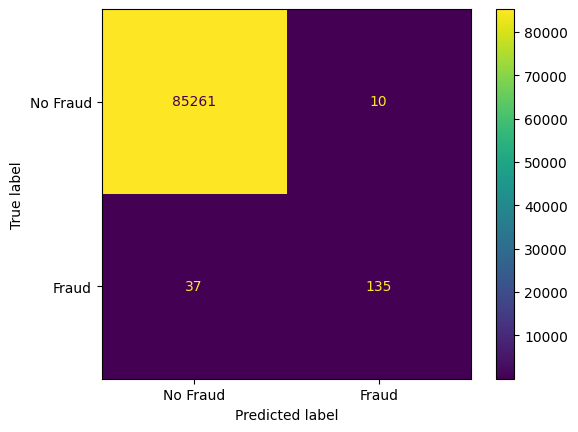

In [7]:
cmat = metrics.confusion_matrix(y_test,y_pred)
display = metrics.ConfusionMatrixDisplay(confusion_matrix=cmat,display_labels=['No Fraud','Fraud'])
display.plot()

One method we can use is AUPRC, or the Area Under the Precision Recall Curve. We define Precision as 
$$ \text{Precision} = \frac{\text{correctly classified true positives}}{\text{everything classified as positive}} = \frac{TP}{TP+FP}$$
and recall as 
$$ \text{Recall} = \frac{\text{correctly classified true positives}}{\text{all actual positives}} = \frac{TP}{TP+FN}$$
The Precision Recall Curve (PRC) is a curve with Precision on the y-axis and Recall on the x-axis. These quantities are evaluated for many probability thresholds (aka. what does the random forest classifier have to output to assign a particular case to fraud?). Reading from left to right on a PRC, one starts where the threshold is high enough such that all the results classified as fraud are classified correctly. However, since recall is low, many of the fraudulent entries are not classified as fraud. Going to the right, the threshold is then decreased in steps to the point where all of the fraudulent entries are classified as fraud. However, this causes many legitimate entries to be classified as fraud. 

Which threshold is right for your problem is a matter to discuss with your team. But there is a metric that can help us determine goodness of fit for a given PRC, regardless of the threshold value chosen. It is called the average precision (AP) and is calculated as the area under the curve. The maximum value this can have is 1, corresponding to a perfect classifier. 

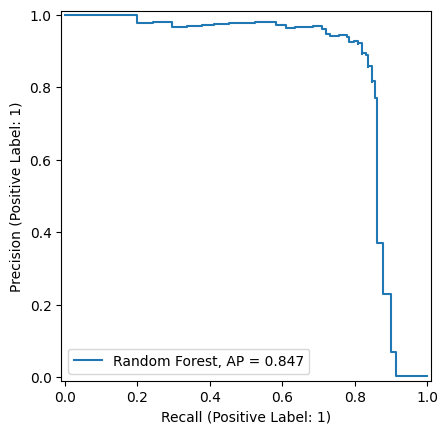

In [8]:
def AUPRC(estimators,names,**kwargs):
    #Since PrecisionRecallDisplay doesn't like plotting multiple curves, I have found the easist way is to do that
    #is call multiple instances and add them to my own graph.
    
    #Both the estimators and names objects should be lists. Dashed in an optional kwarg that is a list 0-indexed indicies
    #of the estimators you want to plot with a dashed line.
    
    #Make multiple instances, grab the coords, average precisions, and close the figure
    xs = []
    ys = []
    aps = []
    for i in range(len(estimators)):
        display = metrics.PrecisionRecallDisplay.from_estimator(estimator=estimators[i],X=X_test,y=y_test,
                                                                name=names[i])
      
        #IMPORTANT you need to use predict_proba (not predict) to get the correct value under the curve
        try:
            ap = metrics.average_precision_score(y_test,estimators[i].predict_proba(X_test)[:,1],pos_label=1)        
        except:
            ap = metrics.average_precision_score(y_test,estimators[i].decision_function(X_test),pos_label=1) 
        aps.append(ap)
        
        line = display.line_
        x,y = line.get_data()
        xs.append(x)
        ys.append(y)
        
        plt.close(display.figure_)

    #make a lookalike PRC plot
    fig, ax = plt.subplots()
    ax.set_xlabel('Recall (Positive Label: 1)')
    ax.set_ylabel('Precision (Positive Label: 1)')
    ax.set_aspect('equal')
    ax.set_xlim(-0.01,1.01)
    ax.set_ylim(-0.01,1.01)
    
    dashed = 'dashed' in kwargs
    for i in range(len(xs)):
        
        label = label=names[i]+', AP = '+str(round(aps[i],3))
        
        if dashed and i in kwargs['dashed']:
            ax.step(xs[i],ys[i],where='post',ls='--',label=label)
        else:
            ax.step(xs[i],ys[i],where='post',ls='-',label=label)    
    ax.legend(loc='best')
    

    
AUPRC([clf],['Random Forest'])

We obtain an AP of 0.847: pretty good! But there are hyperparameters of our random forest model that may be influencing how well our model performs. However, randomly searching across hyperparameters is time-consuming and not a worthwhile manual endeavour. Luckily, scikit-learn includes a tool for this!

### Hyperparameter Tuning
Lets take a look at the parameters our model is currently using

In [9]:
print('Current Parameters')
from pprint import pprint
pprint(clf.get_params())

Current Parameters
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 47,
 'verbose': 0,
 'warm_start': False}


Some of these parameters should not change: like bootstrap. We want all of our random forest models to use bootstrapping. But other parameters, like max_depth or min_samples_leaf, should be explored. For the sake of brevity I will not go over the parameter definitions here. I refer the reader to [the documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for a better understanding of what each parameter means. It is suffisive to say that I will only be including relevant hyperparameters for our estimator setups.

In [10]:
#define the min, max values for hyperparameters
#Integer, Real, and Categorical are classes from skopt that help us explore paramter spaces correctly.
n_estimators = Integer(5,400)
max_depth = Integer(5,100)
max_features = Categorical(['sqrt','log2'])
min_samples_leaf = Integer(1,10)
min_samples_split = Integer(2,10)
criterion = Categorical(['gini', 'entropy', 'log_loss'])

#Create a random grid
random_grid = {'n_estimators':n_estimators,
               'max_depth':max_depth,
               'max_features':max_features,
               'min_samples_leaf':min_samples_leaf,
               'min_samples_split':min_samples_split,
               'criterion':criterion}

pprint(random_grid)

{'criterion': Categorical(categories=('gini', 'entropy', 'log_loss'), prior=None),
 'max_depth': Integer(low=5, high=100, prior='uniform', transform='identity'),
 'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
 'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='identity'),
 'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='identity'),
 'n_estimators': Integer(low=5, high=400, prior='uniform', transform='identity')}


While there are a lot of hyperparameter combinations, we are not testing all of them. A Bayesean search selects hyperparameter combinations using the previous results in the chain to inform its choice. This smarter approach helps us find the best scoring combination in a high-dimensional parameter space while taking up less time investigating combinations we know to score badly.

Additionally, by default BayesSearchCV uses the default score method of the estimator (here a random forest classifier uses accuracy_score) to determine goodness of fit. Since we know that is not a good metric for our unbalanced dataset, we will make a wrapper function around average precision score to be supplied.

In [11]:
#Wrapper of Average Precision to be fed into BayesSearchCV
def AP_wrapper(estimator,X,y):
    try:
        ap = metrics.average_precision_score(y,estimator.predict_proba(X)[:,1],pos_label=1)
    except:
        ap = metrics.average_precision_score(y,estimator.decision_function(X),pos_label=1)
        print(ap)
    return ap

In [12]:
rf_optimizer = BayesSearchCV(estimator = RandomForestClassifier(random_state=47), 
                          search_spaces = random_grid,
                          n_iter = 150,
                          random_state=47,
                          n_jobs = 10,
                          n_points = 10,
                          cv = 3,
                          verbose = 1,
                          scoring = AP_wrapper)

In [13]:
rf_model_available = True #manual flag, set to True if you have a trained model already saved

if rf_model_available == False:
    print('Starting New Optimizer Model')
    
    start = datetime.now()
    rf_optimizer.fit(X,y)
    end = datetime.now()
    
    elapsed_time = (end - start).total_seconds() / 60 #minutes
    print('Fit Completed in {} minutes'.format(str(elapsed_time)))
    
    #Save model to file
    joblib.dump(rf_optimizer,savepath+'opt_rf.pkl')
    
    #Show best hyperparameter combination
    print('Best Parameter Combination',rf_optimizer.best_params_)

elif rf_model_available == True: #aka if file already available just load it
    rf_optimizer = joblib.load(savepath+'opt_rf.pkl')
    print('Best Parameter Combination',rf_optimizer.best_params_)

Best Parameter Combination OrderedDict([('criterion', 'entropy'), ('max_depth', 69), ('max_features', 'log2'), ('min_samples_leaf', 7), ('min_samples_split', 10), ('n_estimators', 119)])


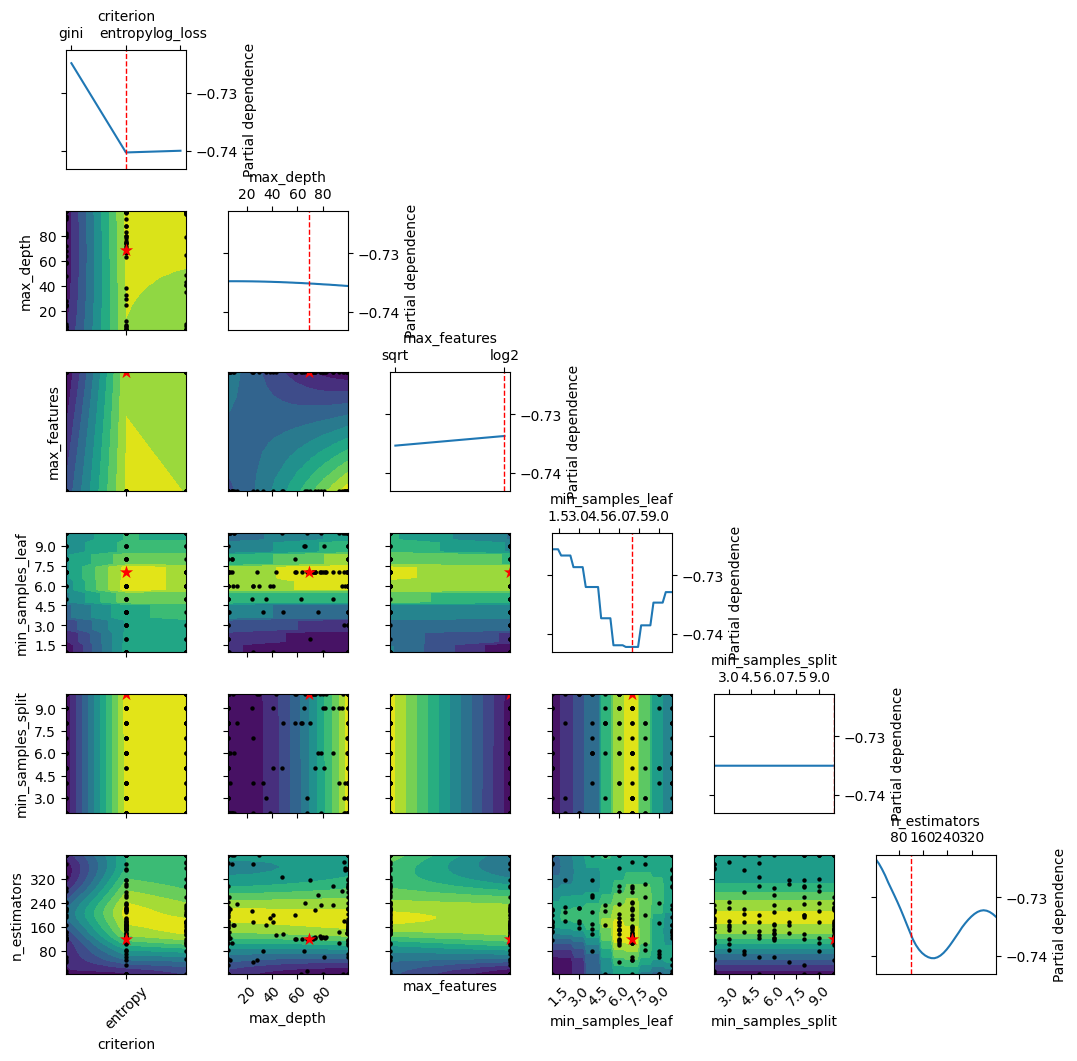

In [14]:
#Make a triangle plot to visualize the parameter distributions
_ = plot_objective(rf_optimizer.optimizer_results_[0],
                   dimensions=["criterion","max_depth", "max_features",'min_samples_leaf',
                               'min_samples_split',"n_estimators"])
                   #Make sure the dimension names are in the same order as in the random_grid variable. 

plt.show()


Above we have a triangle plot describing the parameter space. Along the diagonal are plots of how the partial dependence is affected by each hyperparameter. Partial dependence is a measure of how much a single parameter affects the model while averaging over all of the other parameters. The best fits (denoted by the stars and dashed red line) should be where the partial dependence is at a minimum. (This is a simplification and does not hold for parameters that do not significantly affect the score of a model.) 

On the inside, the points for each of the models we searched through are plotted in 2D parameter spaces. A color gradient (yellow = better here) is also shown. The color gradient is a 2D combination of the partial dependences of the two parameters being compared.

So taking a look here we can see some trends:
* The best criterion is entropy, with log_loss being a close 2nd.
* max_features, min_samples_split, and max_depth do not significantly affect the score of the model.
* min_samples_leaf has a strong affect on scoring ability, preferring ~7. This makes sense, as fitting larger/smaller leaf sizes could lead to under/overfitting
* n_estimators has a strong effect on scoring ability, preferring ~175 trees in the forest. Generally, more trees provide better accuracy. So it is surprising to see a minimum in the partial dependence, since our algorithm does not care about compute-time.

Lets take a look at the AUPRC curve and contrast with the old one.

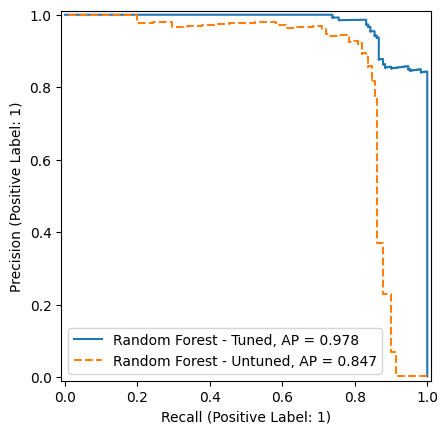

In [15]:
AUPRC([rf_optimizer.best_estimator_,clf],['Random Forest - Tuned','Random Forest - Untuned'],dashed=[1])

As one can see, the tuned curve does much better. It has an average prevision with AP = 0.978, and simply higher precision for all recall values. The tuned precision value stays at (or very close to) 1 until a recall of ~0.8, where that was only at ~0.2 for the previous curve. The difference may not seem like a lot, but fraud classification is serious business. The new tuned model would catch more of the fraudulent transactions while still correctly classifying normal ones. That means less headaches for both the company and the users!

## Support Vector Machines

Support Vector Machines (SVMs) are models that classify points by sorting parameter spaces into distinct regions, and classifying points based on what region they are in. The term to know here is hyperplane: a generalized boundary between two or more N-dimensional spaces. This could be the line separating two 2D regions, a face separating 2 3D regions, or higher-dimensional geometries that are not intuitive to think about.

I am going to use a SVC with a linear kernel. Since scikit-learn's SVC time complexity scales as n^2, and we have many datapoints, I would like to use LinearSVC. But LinearSVC does not support classification probabilities, which are needed to calculate the AUPRC. So while SVC will take longer, it should get us a result we can interpret in an PRC.

(Kernels are mathematical functions that transform your native feature space (your data) into another feature space, where the transformed data may be linearly-separable. To learn more about kernels, I recommend this [webpage](https://medium.com/@abhishekjainindore24/svm-kernels-and-its-type-dfc3d5f2dcd8).)

Below I am going to follow the same steps as above, but modified for SVMs. One notable change is that I will be employing StandardScaler: a function which normalizes each feature to have a mean of 0 and a variance of 1. Some estimators, like SVMs, expect data to be standardized in this way, or gain benefits if it is.

In [16]:
#define the min, max values for hyperparameters
C = Real(1e-5,1e1,prior='log-uniform')


#Create a random grid
random_grid = {'C':C}


pprint(random_grid)

{'C': Real(low=1e-05, high=10.0, prior='log-uniform', transform='identity')}


In [17]:
svc_optimizer = BayesSearchCV(estimator = SVC(random_state=47,kernel='linear',probability=True), 
                          search_spaces = random_grid,
                          n_iter = 50,
                          random_state=47,
                          n_jobs = 10,
                          n_points = 10,
                          cv = 3,
                          verbose = 1,
                          scoring = AP_wrapper)

In [18]:
svc_model_available = True #manual flag

if svc_model_available == False:
    #scale the data
    scaler = StandardScaler()
    scaler.fit(X)
    Xscaled = scaler.transform(X)

    print('Starting New Optimizer Model')
    start = datetime.now()
    svc_optimizer.fit(Xscaled,y)
    end = datetime.now()
    elapsed_time = (end - start).total_seconds() / 60 #minutes
    print('Fit Completed in {} minutes'.format(str(elapsed_time)))
    
    import joblib
    joblib.dump(svc_optimizer,savepath+'opt_svc.pkl')
    
    print('Best Parameter Combination',svc_optimizer.best_params_)

elif svc_model_available == True:
    svc_optimizer = joblib.load(savepath+'opt_svc.pkl')
    print('Best Parameter Combination',svc_optimizer.best_params_)

Best Parameter Combination OrderedDict([('C', 0.005944029962945143)])


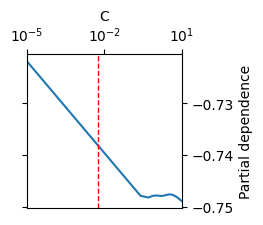

In [19]:
_ = plot_objective(svc_optimizer.optimizer_results_[0],
                   dimensions=["C"])
plt.show()


C (the regularization parameter) was the only relevant hyperparameter to search over, with the many of the others available being related to other kernels, or things not making sense to vary. Looking at the partial dependence we can see that C prefers being a larger value (above ~1). The fact that the best estimator has C = 0.006, well below 1, and C being the only parameter varied over, we can infer that C does not significantly affect the average precision AP. If it did, we would expect a "best" value chosen closer to the minimum of the partial dependence.

/home/alex/miniconda3/envs/portfolio_env/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/alex/miniconda3/envs/portfolio_env/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


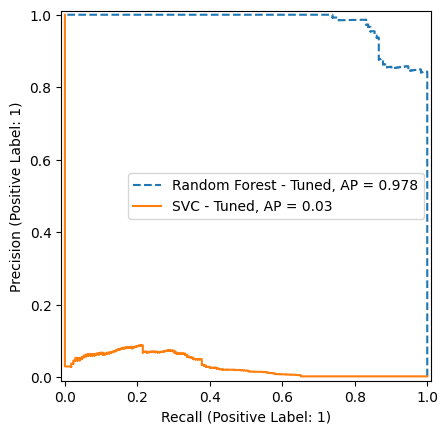

In [20]:
AUPRC([rf_optimizer.best_estimator_,svc_optimizer.best_estimator_],['Random Forest - Tuned','SVC - Tuned'],dashed=[0])

As one can see, our SVC implementation does a bad job at classifying our dataset, with an AP of only 0.03. One explanation of this is that our feature space is not well-separable with a linear kernel. But without the descriptions of the actual features (beyond just V1, V2, etc), it would be very difficult to explain why that is. 

SVC includes other kernel choices, but they are more complex mathematical functions than the linear one. Between the long runtime of the fitting (9 hours) and the much better success of the random forest model, I am choosing to move on. Sometimes certain algorithms are just not a good fit for your problem, and it is more worthwhile to move on and try other ones.

## Logistic Regression

Logistic Regression is a type of classification algorithm that tries to fit the data to a [logistic function](https://en.wikipedia.org/wiki/Logistic_function), where the argument is made up of weighted sets of our parameters. The logistic function is scaled to [0,1] so that once fit, any predictions are the probability (confidence) of being classified as the positive label (1, fraud).

Below I am going to follow the same steps as above, but modified for Logistic Regression. Again I will be using StandardScaler.

In [21]:
#define the min, max values for hyperparameters
solver = Categorical(['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
C = Real(1e-5,1e1,prior='log-uniform')

#Create a random grid
random_grid = {'C':C,
               'solver':solver}

pprint(random_grid)

{'C': Real(low=1e-05, high=10.0, prior='log-uniform', transform='identity'),
 'solver': Categorical(categories=('lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'), prior=None)}


In [22]:
from sklearn.linear_model import LogisticRegression
lr_optimizer = BayesSearchCV(estimator = LogisticRegression(random_state=47,dual=False,penalty='l2',max_iter=500), 
                          search_spaces = random_grid,
                          n_iter = 10,
                          random_state=47,
                          n_jobs = 10,
                          n_points = 10,
                          cv = 3,
                          verbose = 1,
                          scoring = AP_wrapper)

In [23]:
lr_model_available = True #manual flag

if lr_model_available == False:
    #scale the data
    scaler = StandardScaler()
    scaler.fit(X)
    Xscaled = scaler.transform(X)
    
    print('Starting New Optimizer Model')
    start = datetime.now()
    lr_optimizer.fit(X,y)
    end = datetime.now()
    elapsed_time = (end - start).total_seconds() / 60 #minutes
    print('Fit Completed in {} minutes'.format(str(elapsed_time)))
    
    import joblib
    joblib.dump(lr_optimizer,savepath+'opt_lr.pkl')
    
    print('Best Parameter Combination',lr_optimizer.best_params_)

elif lr_model_available == True:
    lr_optimizer = joblib.load(savepath+'opt_lr.pkl')
    print('Best Parameter Combination',lr_optimizer.best_params_)

Best Parameter Combination OrderedDict([('C', 0.00011113917599761135), ('solver', 'newton-cg')])


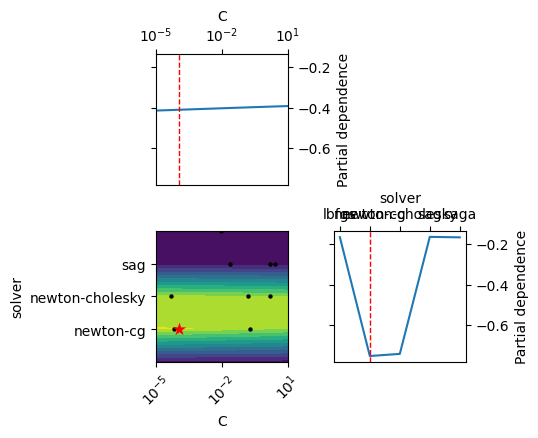

In [24]:
_ = plot_objective(lr_optimizer.optimizer_results_[0],
                   dimensions=["C","solver"])
plt.show()


Analyzing the triangle plot, we see two pieces of information.
* C (the inverse regularization strength) does not significantly affect the AP.
* The choice of solver seems to have a significant effect on the AP. The fitting process threw out some convergence warnings (meaning some of the fits did not converge after 500 iterations), and I suspect this is related to the choice of solver. 'newton-cg', 'newton-cholesky' are the two choices at the minimum of the partial dependence curve. Newton-Cholesky makes sense as a good solver because according to the scikit-learn documentation:
    - ‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories.

/home/alex/miniconda3/envs/portfolio_env/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/alex/miniconda3/envs/portfolio_env/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


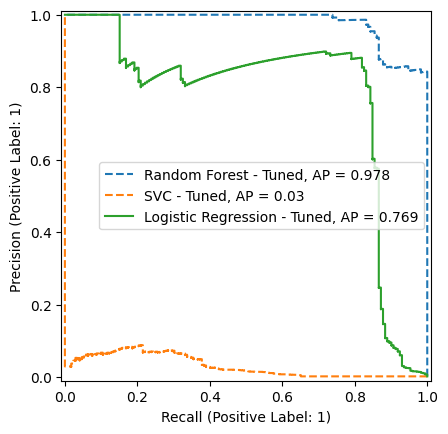

In [25]:
AUPRC([rf_optimizer.best_estimator_,
       svc_optimizer.best_estimator_,
       lr_optimizer.best_estimator_],
      ['Random Forest - Tuned',
       'SVC - Tuned',
       'Logistic Regression - Tuned'],
      dashed=[0,1])

As one can see, the logistic regression implementation does a better job than the SVC with linear kernel, but significantly worse than the random forest implementation. This makes sense if the features of the dataset do not combine well. To fit the logistic function, weighted values of the features are calculated, meaning that all of the values are combined to make one fit. Even when standardized with standardscaler, it is possible that the features are so different that combining them does not make sense to do. Again, without the actual descriptions of the features, it is difficult to say if this is indeed the case.

## Feature Importance

Now that we know that our best model for this classification task is a random forest, and we have a model with tuned hyperparameters, we should take a look at how impactful each of the parameters is to the classification. Let's quickly remind ourselves of the best hyperparameter combination found.

In [26]:
rf_optimizer = joblib.load(savepath+'opt_rf.pkl')
print('Best Parameter Combination',rf_optimizer.best_params_)

Best Parameter Combination OrderedDict([('criterion', 'entropy'), ('max_depth', 69), ('max_features', 'log2'), ('min_samples_leaf', 7), ('min_samples_split', 10), ('n_estimators', 119)])


The random forest instance has an inbuilt feature_importances_ method that measures the mean decrease in impurity for each feature across the trees in the forest. However, this method is sensitive to datasets with high cardinality features (features with many unique values). So a better method is to use scikit-learn's permutation_importance function. This shuffles the features n times and refits the model. A detailed look into how this works can be found [here](https://scikit-learn.org/1.5/modules/permutation_importance.html#permutation-importance).

In [27]:
start = datetime.now()
result = permutation_importance(
    rf_optimizer.best_estimator_, X_test, y_test, n_repeats=10, random_state=47, n_jobs=10)
end = datetime.now()
elapsed_time = (end - start).total_seconds()
print('Feature Importances Completed in {} seconds'.format(str(elapsed_time)))

Feature Importances Completed in 20.068272 seconds


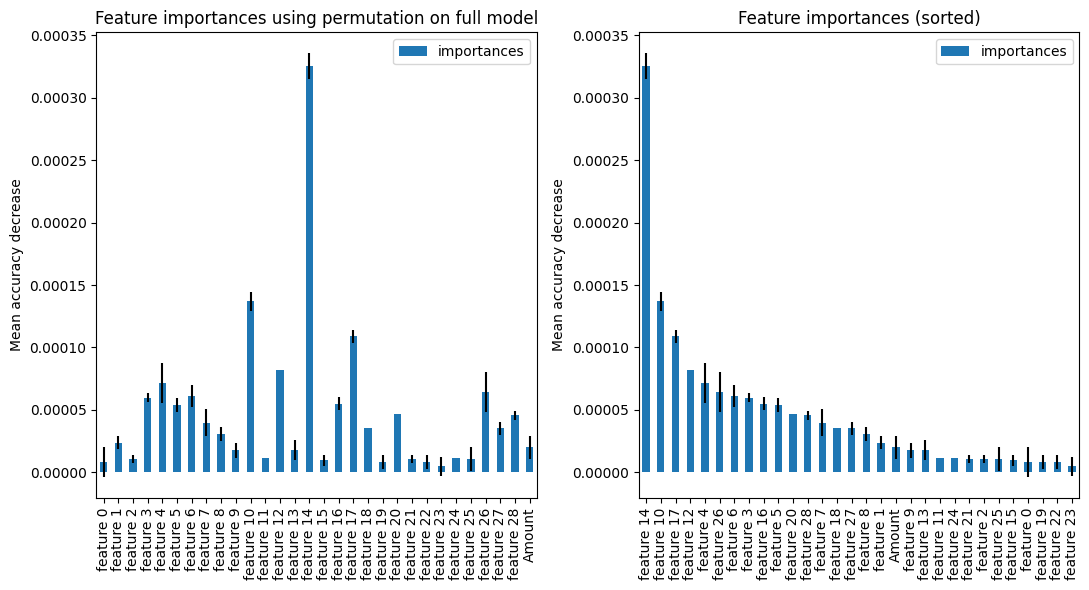

In [28]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names[-1] = 'Amount'
fi = pd.DataFrame(data={'importances':result.importances_mean,'std':result.importances_std},
                  index=feature_names) #fi -> feature importances

fig, ax = plt.subplots(1,2,figsize = (11,6))

fi.plot.bar(y='importances',yerr=fi['std'], ax=ax[0])
ax[0].set_title("Feature importances using permutation on full model")
ax[0].set_ylabel("Mean accuracy decrease")

fis = fi.sort_values(by='importances',ascending=False)
fis.plot.bar(y='importances',yerr=fi['std'], ax=ax[1])
ax[1].set_title("Feature importances (sorted)")
ax[1].set_ylabel("Mean accuracy decrease")

fig.tight_layout()

Finally, we can see the features that are the most important to finding fraud. Feature 14 is the most important, being more than twice as important as the next two features, 10 and 17. Interestingly, "Amount" does not impact the classification very much. My naive guess was that "Amount" would place in the top 5 most important features because I imagine fraudulent transactions to either be a couple large transactions or many many smaller ones. This data has shown my intuition was wrong (for this dataset at least.)